In [1]:
# landcover_osm.py
from __future__ import annotations
from typing import Union, Dict, Any

from shapely.geometry import shape, Polygon, MultiPolygon
import geopandas as gpd
from OSMPythonTools.overpass import Overpass

def _geojson_to_polygon(aoi: Union[Dict[str, Any], Polygon, MultiPolygon]) -> Polygon | MultiPolygon:
    """Accept a GeoJSON dict *or* Shapely geometry and return a Shapely polygon/multipolygon."""
    if isinstance(aoi, (Polygon, MultiPolygon)):
        return aoi
    if isinstance(aoi, dict):
        return shape(aoi)
    raise TypeError("AOI must be a GeoJSON-like dict or a shapely Polygon/MultiPolygon")

def _poly_to_overpass_string(poly: Polygon | MultiPolygon) -> str:
    """Convert exterior ring(s) to the 'lat lon lat lon …' format Overpass expects."""
    if isinstance(poly, Polygon):
        rings = [poly.exterior.coords]
    else:  # MultiPolygon
        rings = [p.exterior.coords for p in poly.geoms]

    parts = []
    for ring in rings:
        parts.extend(f"{lat} {lon}" for lon, lat in ring)
    return " ".join(parts)

def _build_query(coords_str: str) -> str:
    """Raw Overpass QL requesting full geometry for land-use / natural / land-cover."""
    return f"""
    (
      way["landuse"](poly:"{coords_str}");
      way["natural"](poly:"{coords_str}");
      way["landcover"](poly:"{coords_str}");
      relation["landuse"](poly:"{coords_str}");
      relation["natural"](poly:"{coords_str}");
      relation["landcover"](poly:"{coords_str}");
    );
    out geom;
    """

def _elements_to_gdf(result) -> gpd.GeoDataFrame:
    """Convert OSMPythonTools elements → GeoPandas GeoDataFrame (EPSG:4326)."""
    geometries, attrs = [], []
    for el in result.elements():
        tags = el.tags()
        if not tags:
            continue
        geom = shape(el.geometry())
        if not geom.geom_type.startswith("Polygon"):
            continue
        geometries.append(geom)
        attrs.append(tags)

    gdf = gpd.GeoDataFrame(attrs, geometry=geometries, crs="EPSG:4326")
    gdf["cover"] = (
        gdf.get("landuse")
           .fillna(gdf.get("natural"))
           # .fillna(gdf.get("landcover"))
    )
    return gdf

# ---------------------------------------------------------------------------

def get_osm_landcover(
    aoi_geojson: Union[Dict[str, Any], Polygon, MultiPolygon],
    out_crs: str | int = "EPSG:3857",
) -> gpd.GeoDataFrame:
    """
    Retrieve OSM land-use / natural / land-cover polygons intersecting *aoi_geojson*.

    Parameters
    ----------
    aoi_geojson : dict | shapely Polygon/MultiPolygon
        The area of interest.  If dict, must be GeoJSON-like.
    out_crs : str | int, default "EPSG:3857"
        The CRS you want the result in (e.g. 4326, 3857, or any proj string).

    Returns
    -------
    GeoDataFrame
        Columns: all original OSM tag columns + 'cover' (categorical label).
        CRS: *out_crs*.
    """
    # 1. normalise AOI input
    poly = _geojson_to_polygon(aoi_geojson)

    # 2. build & run Overpass query
    overpass = Overpass()
    query = _build_query(_poly_to_overpass_string(poly))
    result = overpass.query(query)

    # 3. convert to GeoDataFrame
    gdf = _elements_to_gdf(result)

    # 4. clip to AOI
    aoi_gs = gpd.GeoSeries([poly], crs="EPSG:4326")
    gdf = gpd.clip(gdf, aoi_gs)

    # 5. project to requested CRS
    if out_crs:
        gdf = gdf.to_crs(out_crs)

    return gdf


In [2]:
# # ── Cell 1 ──  Define a sample AOI (≈ 8 km-wide hexagon in the Santa Monica Mtns)
# sample_geojson = {
#     "type": "Polygon",
#     "coordinates": [[
#         [-118.526522, 34.050000],      # E
#         [-118.548261, 34.081195],      # NE
#         [-118.591739, 34.081195],      # NW
#         [-118.613478, 34.050000],      # W
#         [-118.591739, 34.018805],      # SW
#         [-118.548261, 34.018805],      # SE
#         [-118.526522, 34.050000]       # close ring
#     ]]
# }


# ≈5-mile-wide hexagon centred on Icehouse Canyon (34.250 N, -117.635 W)
sample_geojson = {
    "type": "Polygon",
    "coordinates": [[
        [-117.5915, 34.2500],  # E
        [-117.6133, 34.2860],  # NE
        [-117.6568, 34.2860],  # NW
        [-117.6785, 34.2500],  # W
        [-117.6568, 34.2140],  # SW
        [-117.6133, 34.2140],  # SE
        [-117.5915, 34.2500]   # close ring
    ]]
}


In [3]:
# ── Cell 2 ──  Fetch OSM land-cover / land-use polygons clipped to the AOI
# from landcover_osm import get_osm_landcover
import geopandas as gpd

gdf = get_osm_landcover(sample_geojson, out_crs=3857)  # Web-Mercator for plotting
print(f"{len(gdf):,} polygons returned")
display(gdf.head())


54 polygons returned


,natural,water,landuse,name,sport,leaf_cycle,leaf_type,wood:density,type,geometry,cover
5,scrub,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13092954.454 4057576.418, -13092918...",scrub
20,scree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13092638.752 4061946.615, -13092607...",scree
24,scree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13092676.266 4062375.944, -13092617...",scree
1,scrub,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13091277.648 4062150.908, -13091314...",scrub
25,scree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-13092745.841 4062612.97, -13092678....",scree


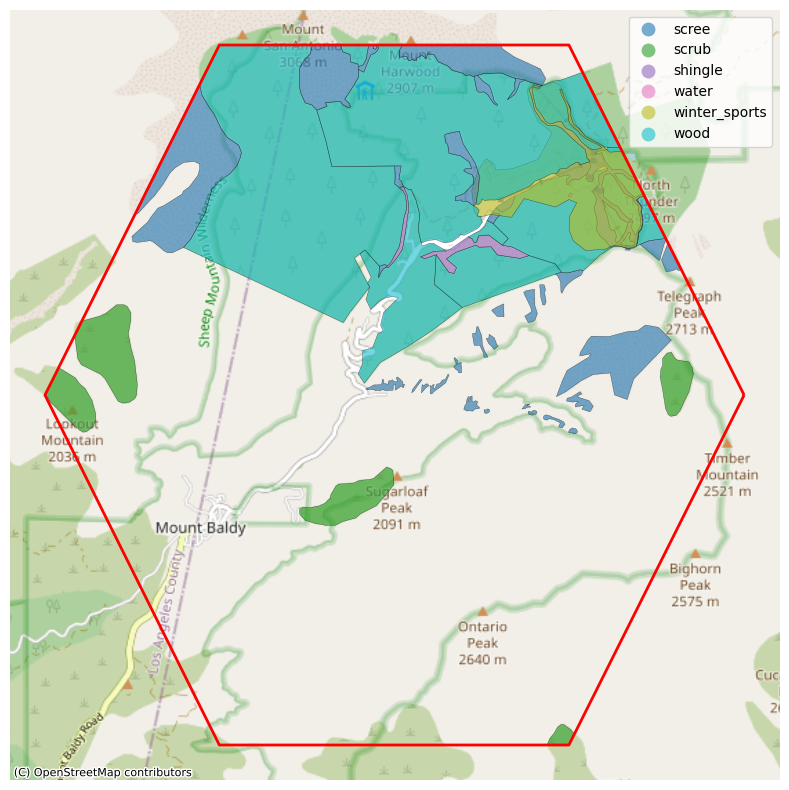

In [4]:
# ── Cell 3 ──  Plot polygons colour-coded by “cover” + AOI outline
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import shape

fig, ax = plt.subplots(figsize=(8, 8))

# land-cover
gdf.plot(
    ax=ax,
    column="cover",
    categorical=True,
    legend=True,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.3,
)

# AOI boundary in red
aoi_web = (
    gpd.GeoSeries([shape(sample_geojson)], crs="EPSG:4326")
    .to_crs(3857)
)
aoi_web.boundary.plot(ax=ax, linewidth=2, color="red")

# Basemap & cosmetics
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [5]:
# postprocess_cover.py
from __future__ import annotations
from typing import Union
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

# ---------------------------------------------------------------------------
def fill_gaps(
    gdf: gpd.GeoDataFrame,
    aoi: Union[Polygon, MultiPolygon, gpd.GeoSeries],
    cover_col: str = "cover",
    gap_tol: float = 5.0,
) -> gpd.GeoDataFrame:
    """
    Fill every polygonal gap inside *aoi* that is not covered by *gdf*.

    Each gap receives the *cover* value of its neighbouring polygon that
    shares the longest common boundary.  Slivers whose smaller dimension is
    ≤ *gap_tol* map units are ignored.

    Parameters
    ----------
    gdf : GeoDataFrame
        Must already be in the same CRS as *aoi*.
    aoi : Polygon | MultiPolygon | GeoSeries
        The AOI boundary (single part).
    cover_col : str, default "cover"
        Column holding the land-cover class.
    gap_tol : float, default 5.0
        Ignore gaps thinner than this (in CRS units, e.g. metres).

    Returns
    -------
    GeoDataFrame
        Original polygons plus any new gap-filling polygons.
    """
    if isinstance(aoi, gpd.GeoSeries):
        aoi_poly = aoi.iloc[0]
    else:
        aoi_poly = aoi

    # 1. union of existing cover polygons
    cover_union = unary_union(gdf.geometry)

    # 2. AOI minus cover layer  →  gaps
    gaps = aoi_poly.difference(cover_union)
    if gaps.is_empty:
        return gdf.copy()

    if isinstance(gaps, Polygon):
        gaps_iter = [gaps]
    elif isinstance(gaps, MultiPolygon):
        gaps_iter = list(gaps.geoms)
    else:
        return gdf.copy()        # no polygonal gaps

    new_rows = []
    for gap in gaps_iter:
        if gap.is_empty:
            continue

        # skip ultra-thin artefacts
        minx, miny, maxx, maxy = gap.minimum_rotated_rectangle.bounds
        if min(maxx - minx, maxy - miny) <= gap_tol:
            continue

        # find neighbours that touch this gap
        neighbours = gdf[gdf.touches(gap)]
        if neighbours.empty:
            continue

        # pick neighbour with the longest shared edge
        shared_len = neighbours.geometry.boundary.intersection(gap.boundary).length
        best_idx   = shared_len.idxmax()
        best_cover = neighbours.loc[best_idx, cover_col]

        new_rows.append({cover_col: best_cover, "geometry": gap})

    if not new_rows:
        return gdf.copy()

    gaps_gdf = gpd.GeoDataFrame(new_rows, crs=gdf.crs)
    return pd.concat([gdf, gaps_gdf], ignore_index=True)


# ---------------------------------------------------------------------------
def dissolve_cover(
    gdf: gpd.GeoDataFrame,
    cover_col: str = "cover",
) -> gpd.GeoDataFrame:
    """
    Dissolve (merge) all adjacent polygons that share the same *cover*.

    Returns a single-part polygon per cover class (explode is applied).
    """
    dissolved = (
        gdf.dissolve(by=cover_col, as_index=False)
           .explode(index_parts=False)
           .reset_index(drop=True)
    )
    return dissolved


# ---------------------------------------------------------------------------
def clean_cover_layer(
    gdf: gpd.GeoDataFrame,
    aoi: Union[Polygon, MultiPolygon, gpd.GeoSeries],
    cover_col: str = "cover",
    gap_tol: float = 5.0,
) -> gpd.GeoDataFrame:
    """
    Convenience wrapper:  gap-fill ➜ dissolve ➜ return cleaned layer.
    """
    filled   = fill_gaps(gdf, aoi, cover_col=cover_col, gap_tol=gap_tol)
    cleaned  = dissolve_cover(filled, cover_col=cover_col)
    return cleaned

# --- ADD to postprocess_cover.py -----------------------------------------
def smooth_cover_layer(
    gdf: gpd.GeoDataFrame,
    cover_col: str = "cover",
    tol: float = 10.0,          # metres; “thickness” threshold to keep
    min_area: float | None = None,
) -> gpd.GeoDataFrame:
    """
    Morphological smoothing: removes / rounds features thinner than *tol*.

    1. Erode polygons by *tol*  (buffer negative)
    2. Dilate by *tol*          (buffer positive)
       → strips corridors & spikes < 2×tol and smooth-rounds boundaries.
    3. Drop parts whose area < *min_area*
    4. Dissolve by *cover*.

    Parameters
    ----------
    gdf : GeoDataFrame
        Input layer.
    cover_col : str, default "cover"
        Column holding land-cover class.
    tol : float, default 10.0
        Thickness threshold (units = CRS units, usually metres).
    min_area : float | None
        Minimum area to keep (units²).  Default is *tol²*.

    Returns
    -------
    GeoDataFrame
        Smoothed layer.
    """
    if min_area is None:
        min_area = tol ** 2

    new_geoms, new_cover = [], []

    for cov, geom in zip(gdf[cover_col], gdf.geometry):
        try:
            g = geom.buffer(-tol).buffer(tol)
        except ValueError:
            # occasionally a geometry is so tiny that buffer throws; skip it
            continue

        if g.is_empty:
            continue

        # explode multi-parts so we can area-filter
        parts = g.geoms if g.geom_type == "MultiPolygon" else [g]
        for p in parts:
            if p.area >= min_area:
                new_geoms.append(p)
                new_cover.append(cov)

    if not new_geoms:
        return gdf.copy()

    smoothed = gpd.GeoDataFrame(
        {cover_col: new_cover, "geometry": new_geoms}, crs=gdf.crs
    )

    return (
        smoothed
        .dissolve(by=cover_col, as_index=False)
        .explode(index_parts=False)
        .reset_index(drop=True)
    )


<Axes: >

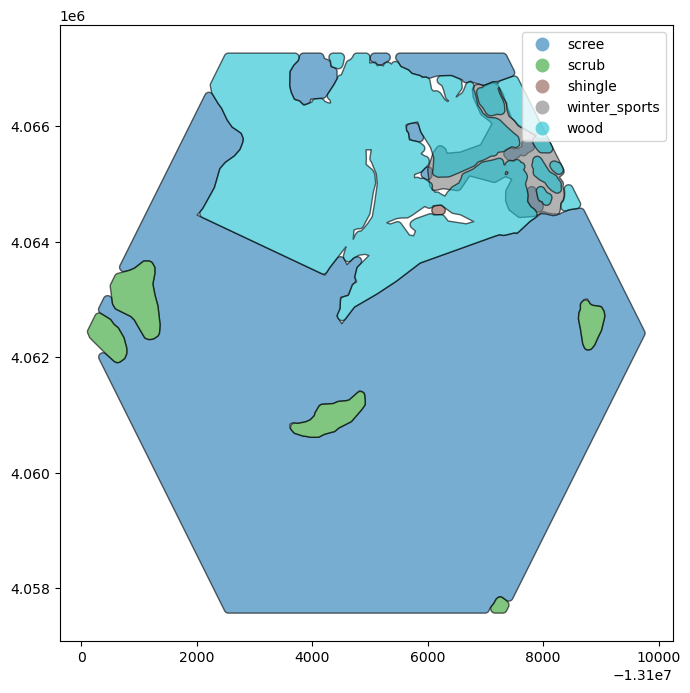

In [13]:
# ------------------------------------------------------------------
# 1.  Fetch raw OSM polygons (previous steps)
gdf_raw = get_osm_landcover(sample_geojson, out_crs=3857)

# 2.  Post-process
# from postprocess_cover import clean_cover_layer

aoi_web = (
    gpd.GeoSeries([shape(sample_geojson)], crs="EPSG:4326")
        .to_crs(3857)
)


# 1. fetch raw polygons → gdf_raw   (earlier steps)
# 2. gap-fill + dissolve
gdf_clean = clean_cover_layer(gdf_raw, aoi_web, gap_tol=5)

# 3. OPTIONAL: extra smoothing (e.g. strip things < 10 m thick)
gdf_smooth = smooth_cover_layer(gdf_clean, tol=75)

# 4. Plot
gdf_smooth.plot(column="cover", figsize=(8, 8), legend=True, alpha=0.6, edgecolor="k")
